In [1]:
import numpy as np
from PIL import Image
from Scripts import SpatialCorrelations as corr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pymks
import pandas as pd
import os
from Scripts import velocityCalculations as vel
from Scripts import hoshenKopleman as hosh
import math
import time
from numpy import linalg as LA
import seaborn as sns
from Scripts import plots as plot

/home/sushil/anaconda3/envs/env_adi/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sushil/anaconda3/envs/env_adi/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


--- 4.472656011581421 seconds ---


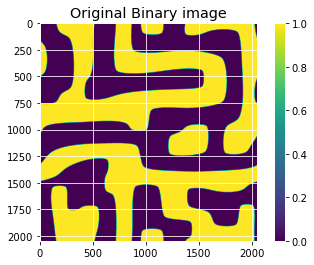

--- 4.916065454483032 seconds ---


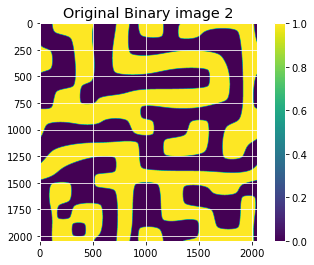

In [2]:
path = '/home/sushil/Desktop/adithya/CUBIC/c0.5/'
list_of_files = os.listdir(path)
list_of_files.sort()
list_files = []
for i in list_of_files:
    if i[-5:]=='0.dat':
        list_files.append(path+i)
   
start_time = time.time()
img_ = corr.dat_to_numpy(list_files[999])
img_ = vel.gaussian_filter(img_,4)
img_ = (img_>0.5)*1
print("--- %s seconds ---" % (time.time() - start_time))
plt.imshow(img_)
plt.colorbar()
plt.title('Original Binary image')
plt.show()

path2 = '/home/sushil/Desktop/adithya/CUBIC/c0.5/'
list_of_files2 = os.listdir(path2)
list_of_files2.sort()
list_files2 = []
for i in list_of_files2:
    if i[-5:]=='0.dat':
        list_files2.append(path2+i)
   
start_time = time.time()
img_1 = corr.dat_to_numpy(list_files2[700])
img_1 = vel.gaussian_filter(img_1,4)
img_1 = (img_1>0.5)*1
print("--- %s seconds ---" % (time.time() - start_time))
plt.imshow(img_1)
plt.colorbar()
plt.title('Original Binary image 2')
plt.show()

In [3]:
def root(arr, i):
    j = i
    try:
        while j != arr[j]:
            arr[j] = arr[arr[j]]
            j = arr[j]
    except:
        print(j, ' ', len(arr))
    return j

def find(arr, p, q):
    return root(arr,p)==root(arr,q)

def union(arr1,sz1, p, q):
    arr=arr1
    sz=sz1
    
    i = arr[p]
    j = arr[q]
    if (sz[i] < sz[j]):
        arr[i] = j
        sz[j] =sz[j]+ sz[i]
    else:
        arr[j] = i
        sz[i] =sz[i]+ sz[j]
    
    return arr, sz
    
        

def hoshya(img_):
    properLabels = []
    sz = []
    properLabels.append(0)
    sz.append(1)
        
    start = time.time()
    
    largestLabel = 0
    labels = np.zeros(img_.shape).astype('int32')
    for j in range(img_.shape[0]):
        for i in range(img_.shape[1]):
            if img_[j][i] == 1:
                if i>0 and j>0:
                    left = img_[j][i-1]
                    above = img_[j-1][i]
        
                    if left==0 and above== 0:
                        largestLabel=largestLabel+1
                        labels[j][i] = largestLabel
                        properLabels.append(largestLabel)
                        sz.append(1)
                    
                    if left==1 and above== 0:
                        labels[j][i] = root(properLabels,labels[j][i-1])
                    if left==0 and above== 1:
                        labels[j][i] = root(properLabels,labels[j-1][i])
                    if left==1 and above== 1:
                    
                        if labels[j][i-1]!= labels[j-1][i]:
                            if labels[j][i-1]!= labels[j-1][i]:
                                properLabels, sz= union(properLabels,sz,int(labels[j][i-1]),int(labels[j-1][i]))
                                labels[j][i] = root(properLabels,int(labels[j-1][i]))
                                
#                             if labels[j][i-1]< labels[j-1][i]:
#                                 properLabels , sz=union(properLabels,sz,int(labels[j-1][i]),int(labels[j][i-1]))
#                                 labels[j][i] = root(properLabels,int(labels[j][i-1]))
                        else:
                            labels[j][i] = root(properLabels,labels[j][i-1])
                        
                if i == 0 and j == 0:
                    if img_[j][i] == 1:
                        largestLabel=largestLabel+1
                        labels[j][i] = largestLabel
                        properLabels.append(largestLabel)
                        sz.append(1)
                if i == 0 and j>0:
                    above = img_[j-1][i]
                    if img_[j][i] == 1:
                        if above==1:
                            labels[j][i] = root(properLabels,labels[j-1][i])
                        if above==0:
                            largestLabel=largestLabel+1
                            labels[j][i] = largestLabel
                            properLabels.append(largestLabel)
                            sz.append(1)
                if i>0 and j==0:
                    left = img_[j][i-1]
                    if img_[j][i] == 1:
                        if left==1:
                            labels[j][i] = root(properLabels,labels[j][i-1])
                    
                        if left==0 :
                            largestLabel=largestLabel+1
                            labels[j][i] = largestLabel
                            properLabels.append(largestLabel)
                            sz.append(1)
    
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i][j]!=0:
                labels[i][j] = root(properLabels,labels[i][j])
                
    print('L1',time.time()-start, 'secs')
    
    
    
    #------------------ 2nd Loop starts here--------------------------#
    
    start = time.time()
    for j in range(img_.shape[0]):
        for i in range(img_.shape[1]):
            if img_[j][i] == 1:
                # part 1
                if i==0 or j==0:
                    iminus1 = img_.shape[1]-1 
                    jminus1 = img_.shape[0]-1
                    
                    left = img_[j][iminus1]
                    above = img_[jminus1][i]
                    if left==1 and above== 0:
                        properLabels,sz=union(properLabels,sz,int(labels[j][i]),int(labels[j][iminus1]))
                        
                    if left==0 and above== 1:
                        properLabels,sz=union(properLabels,sz,int(labels[j][i]),int(labels[jminus1][i]))
                        
                    if left==1 and above== 1:
                        if labels[j][iminus1]!= labels[jminus1][i]:
                            properLabels,sz=union(properLabels,sz,int(labels[jminus1][i]),int(labels[j][iminus1]))
                            
    
                
    print('L2',time.time()-start, 'secs')
    start = time.time()
    listy ={}
    num=0
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            if labels[i][j]!=0:
                labels[i][j] = root(properLabels,labels[i][j])
                if labels[i][j] in listy.keys():
                    labels[i][j]=listy[labels[i][j]]
                else:
                    num=num+1
                    listy[labels[i][j]]=num
                    labels[i][j]=num
    print('L3',time.time()-start, 'secs')  
    return labels

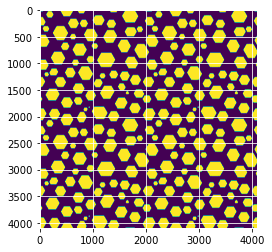

In [20]:
img_2 = np.zeros((4096,4096))

img_2[0:2048,0:2048]=img_1
img_2[0:2048,2048:4096]=img_1
img_2[2048:4096,0:2048]=img_1
img_2[2048:4096,2048:4096]=img_1
plt.imshow(img_2)


    
    
    

L1 15.927829027175903 secs
L2 1.3616344928741455 secs
L3 13.88722848892212 secs
31.177118062973022 secs taken


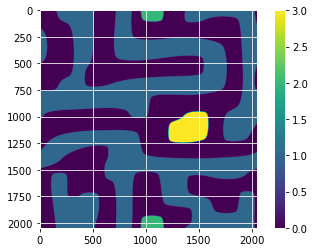

In [3]:
start =time.time()
labels = hosh.hoshenKoplemanLabels(img_)
print(time.time()-start,'secs taken')
plt.imshow(labels)
plt.colorbar()

In [26]:
for i in range(2048):
    print(labels[i,400])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


0


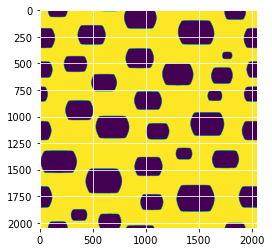

1


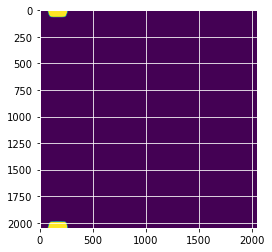

2


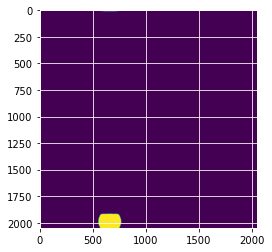

3


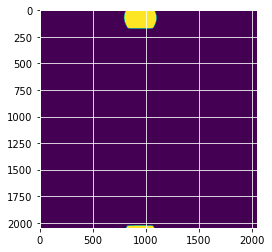

4


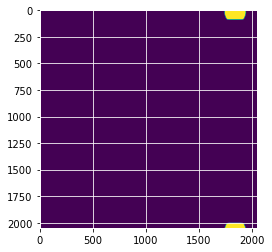

5


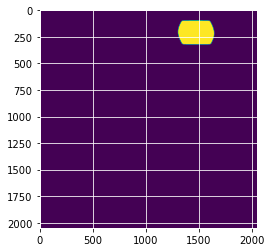

6


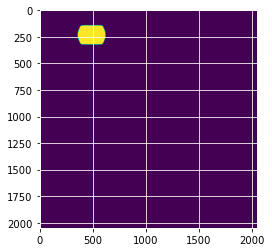

7


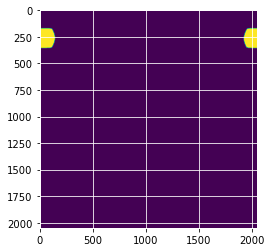

8


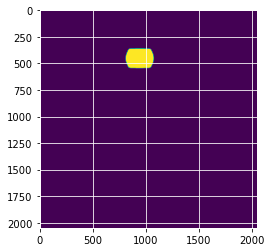

9


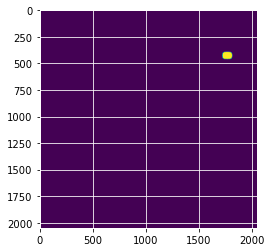

10


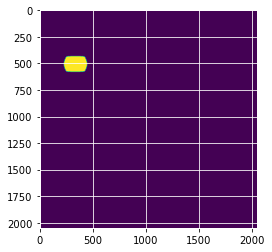

11


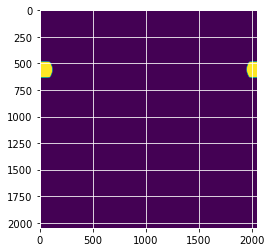

12


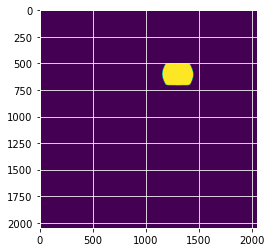

13


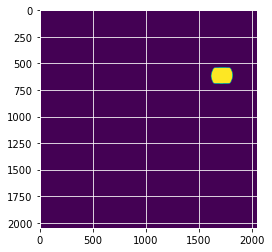

14


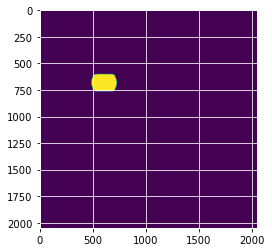

15


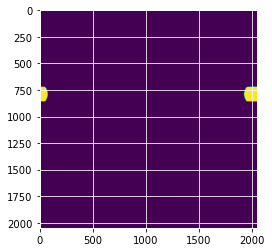

16


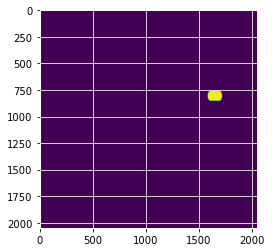

17


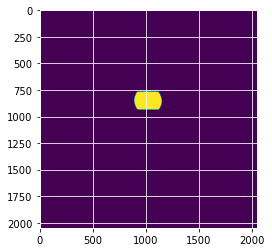

18


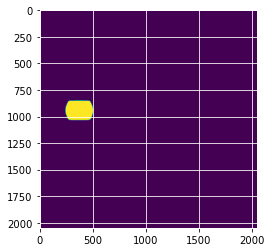

19


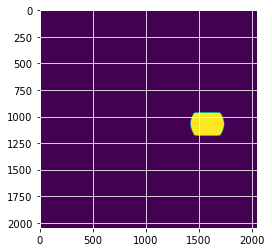

20


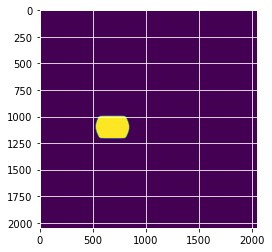

21


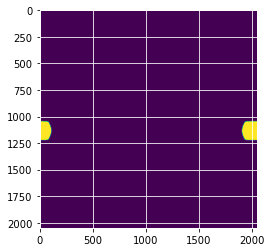

22


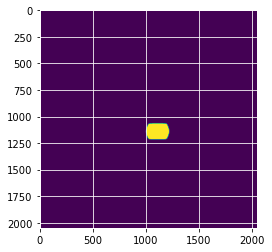

23


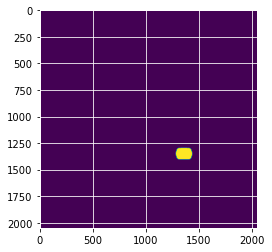

24


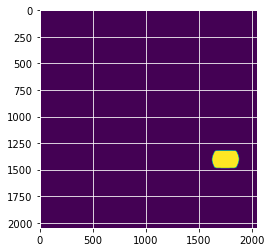

25


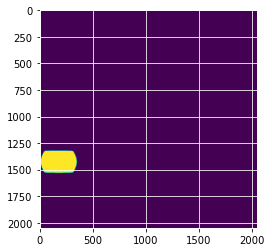

26


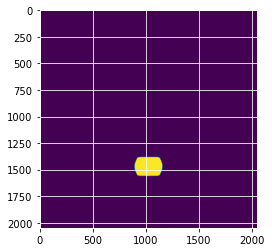

27


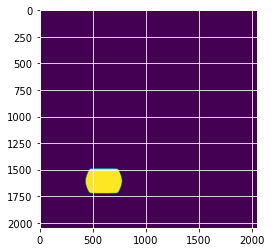

28


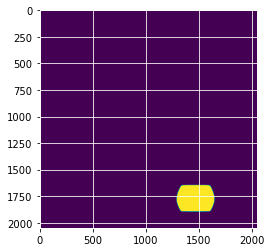

29


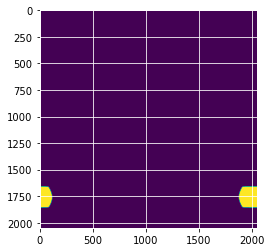

30


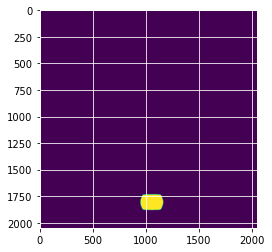

In [22]:
for i in range(0,31):
    print(i)
    plt.imshow((labels==i)*1)
    plt.show()

In [175]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37], dtype=int32)